In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time

spectra_path        =   '../BRILLOUIN/Claudia/DaticellBoniPuntiDoppi/'
spectra_filename    =   '20191218_K27M'

VIPA_path           =   '../BRILLOUIN/Claudia/DaticellBoniPuntiDoppi/picchi_elastici_con_filtro_100msexp/Pos0/'
VIPA_filename       =   'img_000000000_Default_000.tif'


syg_kwargs          =   {'height': 20, 'distance': 20, 'width': 5.}
syg_kwargs_brill    =   {'height': 20, 'distance': 20, 'width': 5.}

cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat
Lo spettro è bono


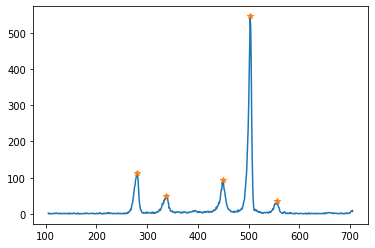

In [2]:
#0) importo dati e inizializzo oggetti
i   =   29
j   =   74

y    =   Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = True, cut_range = (100, 680))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, VIPA_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks[0]], Data.y[Data.peaks[0]], '*')


check = Data.Check_Spectrum(saturation_width = 13.5)

if      check == 1  : nature    = 'saturo'
elif    check == 2  : nature    = 'brillouin_higher'
elif    check == 3  : nature    = 'invisible'
else:                 nature    = 'bono'
print('Lo spettro è '+nature)

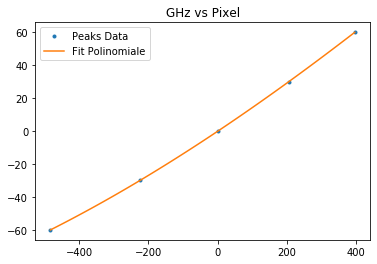

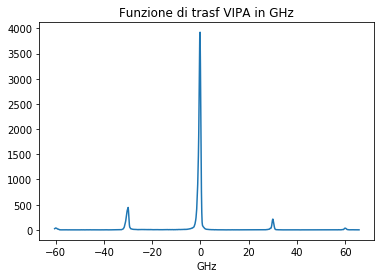



Ho stimato 12 parametri iniziali per il fit che andrai a fare

Co  = 1.000 

Omega  = 7.530 

Gamma  = 1.119 

Delta  = 1.119 

tau  = 100.000 

delta_width  = 0.500 

delta_amplitude  = 1.000 

A  =  nan 

mu  =  nan 

sigma  =  nan 

shift  = 0.000 

offset  = 12.380 

Ho stimato i parametri della gaussiana come A = 3965.50	mu  = -2.09	sigma = -13.30
E li ho aggiunti ai parametri iniziali per il fit. Ora conosco 12 parametri su 12 



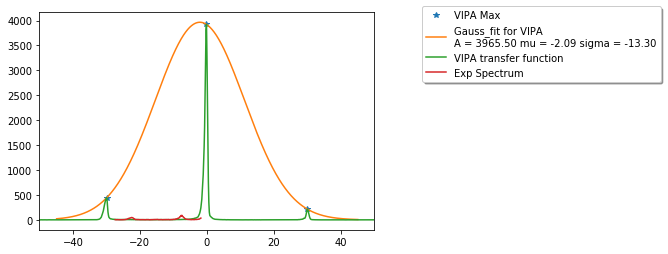

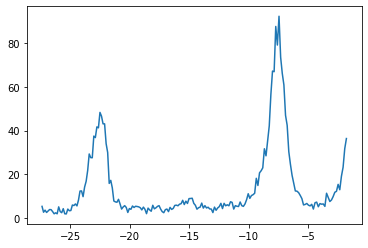

In [3]:
#1) Operazioni di modifica Spettro

Data.How_Many_Peaks_To_VIPA(treshold = 30)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)
Data.Spectrum_Pix2GHz()

if nature == 'brillouin_higher':  

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    Data.Get_Spectrum_4_Peaks_by_Order()

else:           

    Data.Get_Spectrum_4_Peaks_by_Height()

Data.Cut_n_Estimate_Spectrum(estimate = True, verbose = True, distanza = 0.25)
Data.Fit_VIPA_Gaussian(verbose = True, fig = True)
plt.figure()
plt.plot(Data.x_freq, Data.y)

costo = 157851.44008516503
s impiegati a fare il fit  12.021229024 

costo dopo fit = 45.575022052146004
                Co     Omega     Gamma  delta_width  delta_amplitude  \
Values    0.080750  7.463781  0.143619     0.904015         0.031496   
StdErrs   0.094688  0.024930  0.015570     0.196671         0.023996   
Initials  1.000000  7.529681  1.118975     0.500000         1.000000   

                     A         mu      sigma     shift     offset  
Values    3.734389e+03  -1.877295 -12.397466  0.141044   2.227953  
StdErrs   8.635306e+09  29.224222  13.291379  0.025876   0.324071  
Initials  3.965503e+03  -2.085884 -13.301333  0.000000  12.379548  
Valore stimato della cost function prima del fit:
45.575022052146004


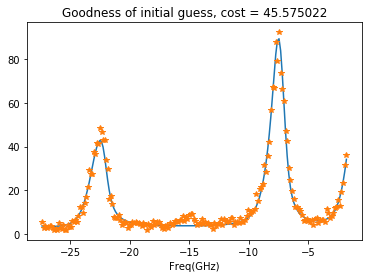

In [4]:
#3) fit markoviano

Data.Estimate_Initial_Parameters(p0 = Data.p0.values[0], treshold = 1000, columns = cols_mark)
print(Data.Fit_Params)
Data.Take_A_Look_Before_Fitting()

Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5575e+01                                    5.93e-01    
       1              2         4.5389e+01      1.87e-01       1.00e+02       1.26e+01    
       2              6         4.5314e+01      7.45e-02       6.60e+00       2.95e+00    
       3              8         4.5243e+01      7.12e-02       1.65e+00       1.86e+00    
       4             10         4.5239e+01      3.66e-03       7.90e-01       3.44e-01    
       5             11         4.5239e+01      2.69e-04       1.66e-01       1.88e-01    
       6             12         4.5239e+01      6.62e-05       3.32e-01       3.20e-01    
       7             16         4.5239e+01      3.21e-05       4.98e-02       1.79e-01    
       8             17         4.5239e+01      1.55e-05       3.77e-02       3.06e-02    
       9             18         4.5239e+01      9.03e-06       1.04e-02       3.00e-02    
  

2

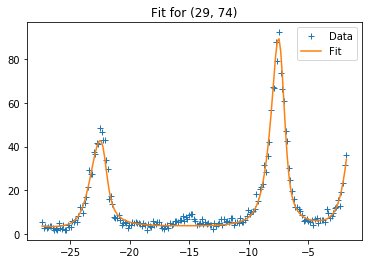

In [5]:
#4) fit totale
percents                    =   (0.2, 0.1, 0.15, 'positive', 'positive', 0.15, 0.15, np.inf, np.inf)
Data.Get_Fit_Bounds(percents, columns = cols_real)
p_gauss = Data.p0[list(cols_gauss)].values[0]
p0      = Data.p0[list(cols_real)].values[0]
Data.Non_Linear_Least_Squares(p0, p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 200)


In [6]:
Data.Fit_Params

,Co,Omega,Gamma,Delta,tau,delta_width,delta_amplitude,shift,offset
Values,0.083846,7.180348,0.149305,108.866247,104.010594,0.906692,0.029575,0.139207,2.204901
StdErrs,0.008765,0.736930,0.024812,3667.659885,3303.131705,0.213359,0.032633,0.024373,0.637251
Initials,0.080750,7.463781,0.143619,0.143619,100.000000,0.904015,0.031496,0.141044,2.227953
